In [1]:
using Crystalline, MPBUtils, JLD2, LinearAlgebra, StaticArrays, SymmetryBases, PyPlot, DelimitedFiles, PrettyTables, Brillouin
using PyCall
np = pyimport("numpy")

PyObject <module 'numpy' from '/home/gridsan/aligho/.local/lib/python3.8/site-packages/numpy/__init__.py'>

In [2]:
# Finding Good Candidates For C6 Symmetry

In [19]:
function wigner_seitz(k::Vector{<:Real}, Gs::ReciprocalBasis)
    b1, b2 = Gs
    kbasis = hcat(b1, b2)
    return kbasis*k
end

wigner_seitz (generic function with 1 method)

In [20]:
good_candidatesv = Dict{Tuple{String, Integer, Integer, Integer}, Float64}[] #mode, id_eps, id, top band, margin (total id including id_eps offset) 
                                                                # This is a vector- each element corresponds to sgs 2, 10, 16 respectively
#good_candidatesv_unrestricted = Dict{Tuple{String, Integer, Integer, Integer}, Float64}[] #mode, id_eps, id, top band, margin (total id including id_eps offset) 
for sg in [2, 10, 16]
    println("Calculating for sg: $sg"); flush(stdout)
    good_candidates = Dict{Tuple{String, Integer, Integer, Integer}, Float64}() # Dictionary for each space group
    #good_candidates_unrestricted = Dict{Tuple{String, Integer, Integer, Integer}, Float64}() # Dictionary for each space group
    # By unrestricted we mean that we don't restrict within the first few band groupings
    for id_eps in 1:3
        println("Calculating for id_eps: $id_eps"); flush(stdout)
        for mode = ["te", "tm"];
            dispersion_dir = "./dispersions/output/sg$sg/eps$(id_eps)/$mode/";
            loaded_dispersion_data = load(dispersion_dir*"sg$sg-epsid$(id_eps)-res64-$mode.jld2")
            marginsv = loaded_dispersion_data["marginsv"];
            cumsummariesv = loaded_dispersion_data["cumsummariesv"];
            for (id, (margins, cumsummaries)) in enumerate(zip(marginsv, cumsummariesv))
                real_id = id + (10000)*(id_eps-1)
                for (cumsum_idx, (margin, cumsummary)) in enumerate(zip(margins, cumsummaries))
                    #push!(good_candidates_unrestricted, (mode, id_eps, real_id, top_band) => margin)
                    if cumsum_idx <= 3
                        cumsummary.topology == NONTRIVIAL || continue
                        top_band = cumsummary.band[end]
                        push!(good_candidates, (mode, id_eps, real_id, top_band) => margin)
                    end
                end
            end
        end
    end
    push!(good_candidatesv, good_candidates)
    #push!(good_candidatesv_unrestricted, good_candidates_unrestricted)
end

Calculating for sg: 2
Calculating for id_eps: 1
Calculating for id_eps: 2
Calculating for id_eps: 3
Calculating for sg: 10
Calculating for id_eps: 1
Calculating for id_eps: 2
Calculating for id_eps: 3
Calculating for sg: 16
Calculating for id_eps: 1
Calculating for id_eps: 2
Calculating for id_eps: 3


In [22]:
nodal_point_calcnames = String[]
nodal_point_data = Dict{String, Tuple{Float64, Integer}}()
for (good_candidates, sg) in zip(good_candidatesv, [2, 10, 16])
    best_candidates = collect(sort(good_candidates, byvalue=true, rev=true))
    for best_candidate in best_candidates[1:10]
        (mode, id_eps, id, band), margin = best_candidate #findmax(good_candidates)
        push!(nodal_point_data, "dim2-sg$sg-$id-res64-$mode" => (margin, band))
        #println(band)
        push!(nodal_point_calcnames, "dim2-sg$sg-$id-res64-$mode")
        #println("Best candidate for sg $sg is:\nMode: $mode\nid_eps:$id_eps\nid: $id\ntop band: $band\nwith margin: $margin" )
    end
    #println("\n\n")
end

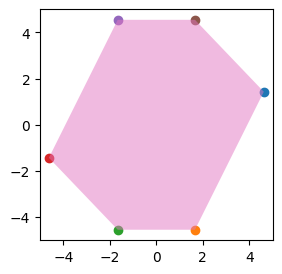

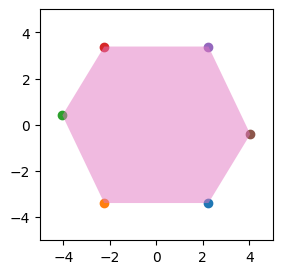

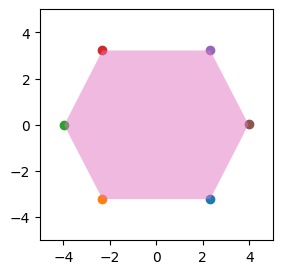

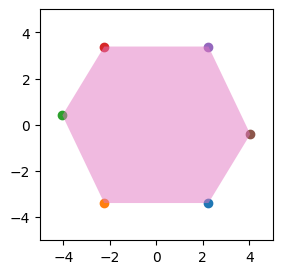

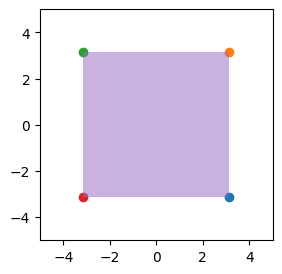

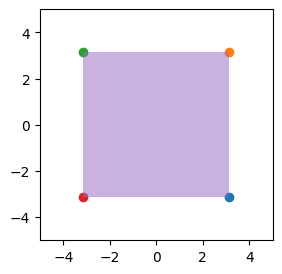

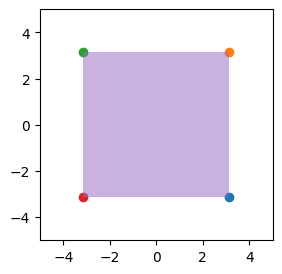

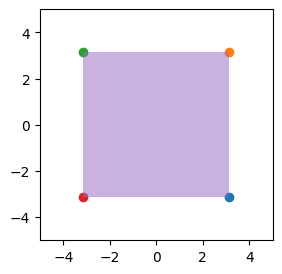

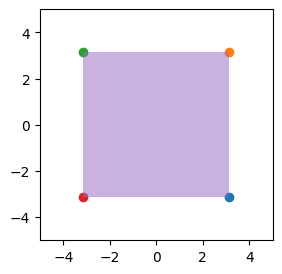

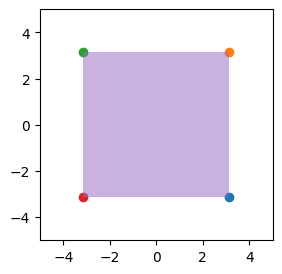

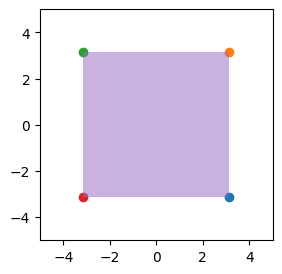

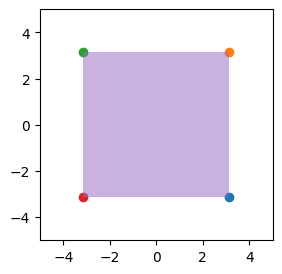

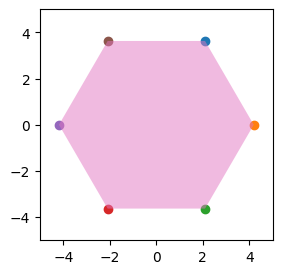

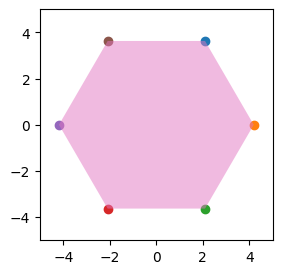

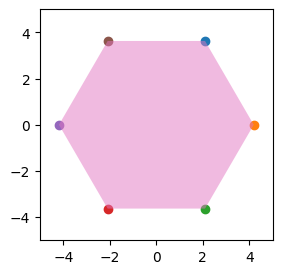

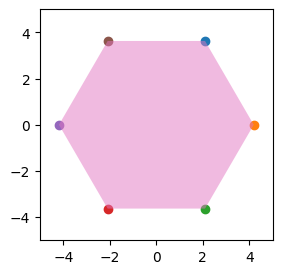

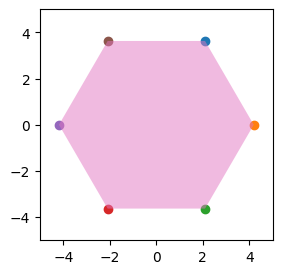

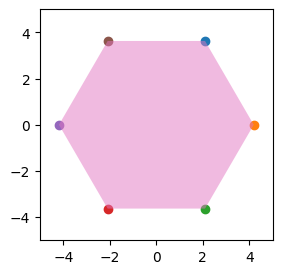

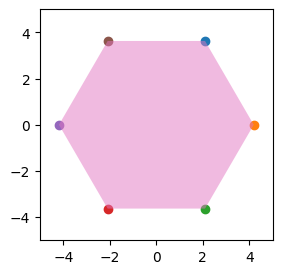

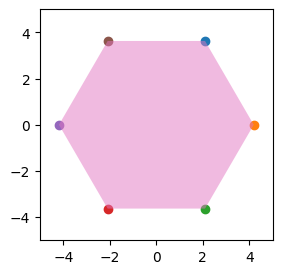

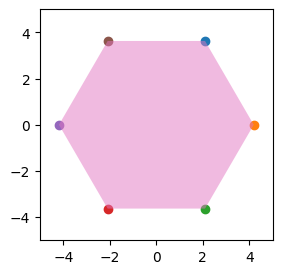

In [23]:
for nodal_point_calcname in nodal_point_calcnames
    xs = []
    ys = []

    Rs = first(lattice_from_mpbparams("./nodal_points/input/"*nodal_point_calcname*".sh"))
    Gs = reciprocalbasis(Rs)
    verts = wignerseitz(Gs).verts;
    faces = wignerseitz(Gs).faces;
    figure(figsize=(3, 3))
    for vert in verts
        x, y = Gs[1]*vert[1] + Gs[2]*vert[2]
        scatter(x, y)
        push!(xs, x)
        push!(ys, y)
    end
    fill(xs, ys, alpha=0.5)
    xlim(-5, 5)
    ylim(-5, 5)
end

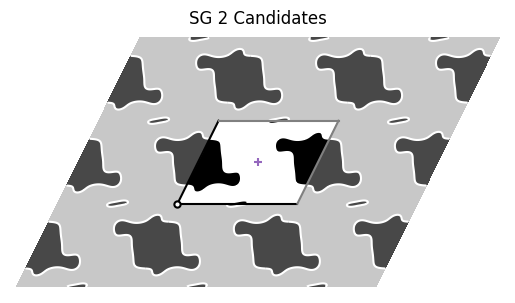

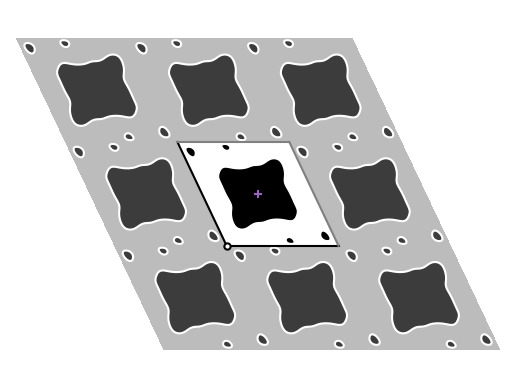

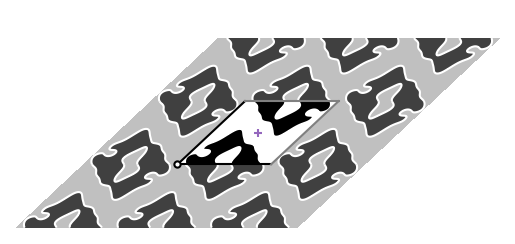

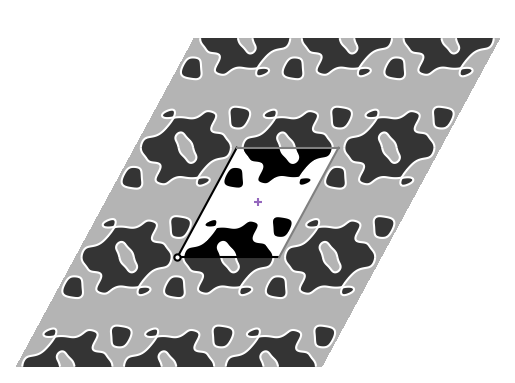

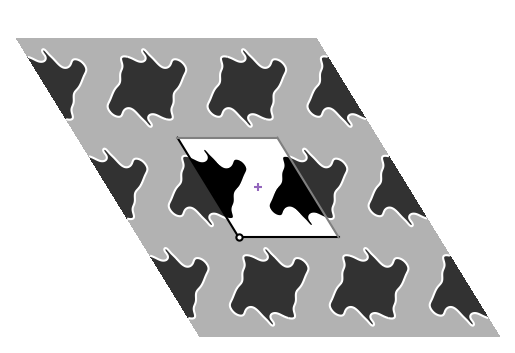

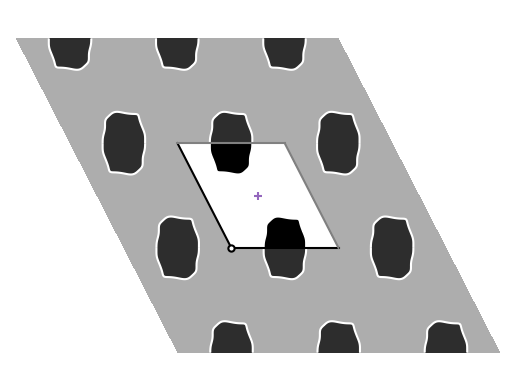

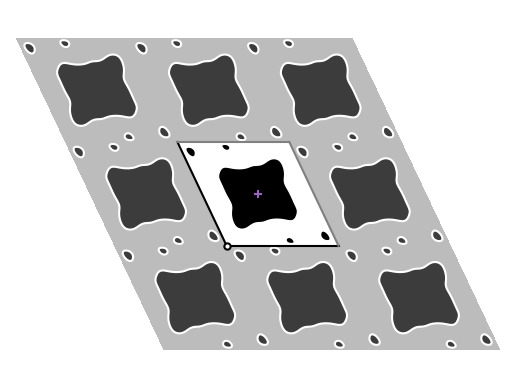

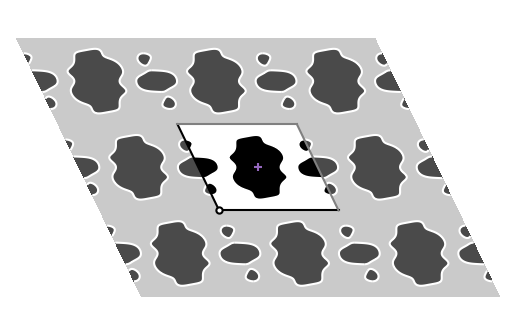

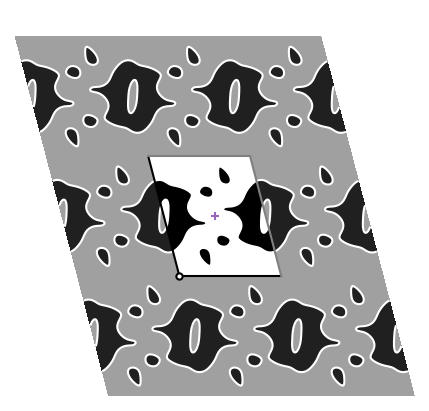

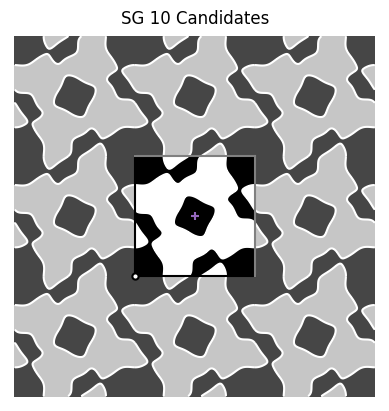

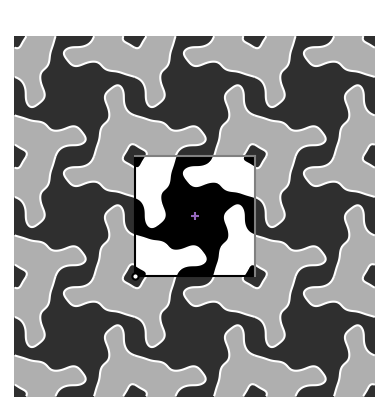

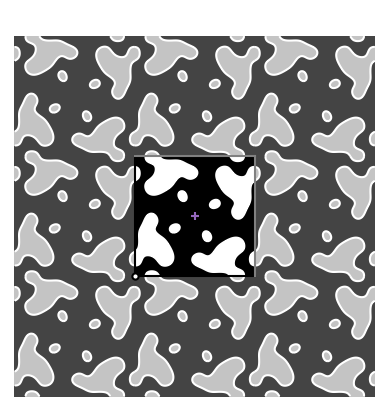

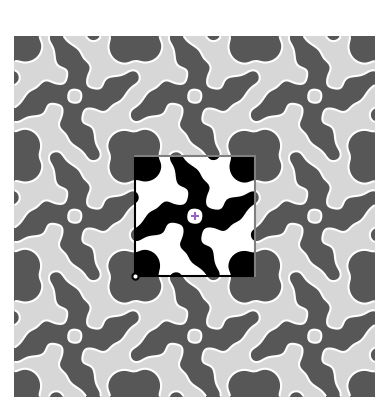

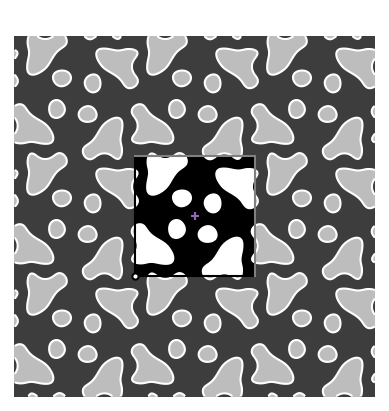

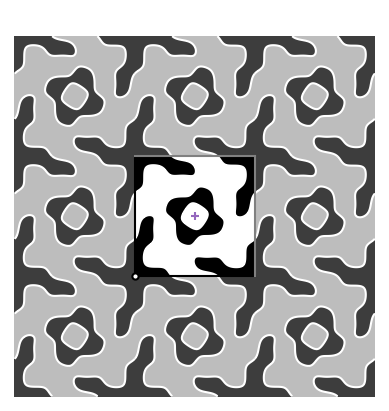

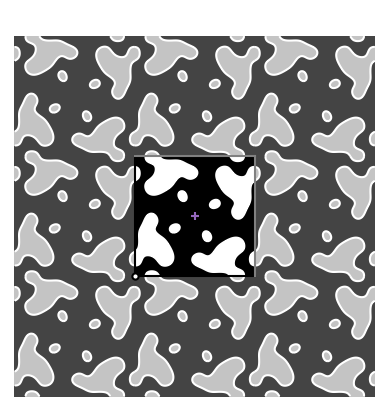

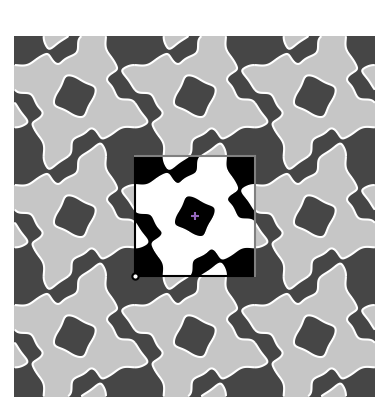

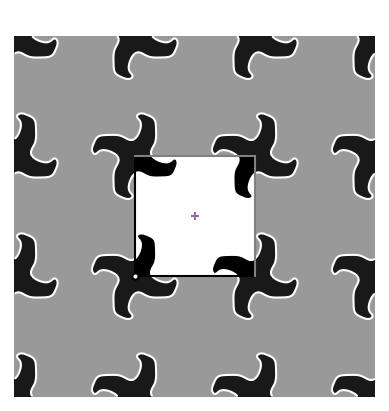

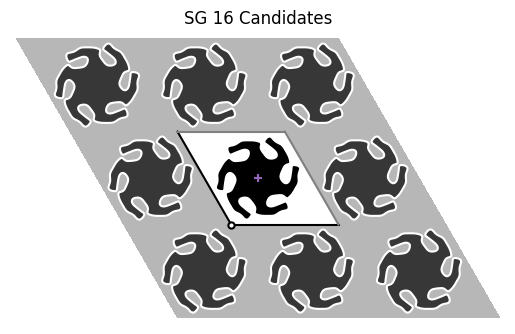

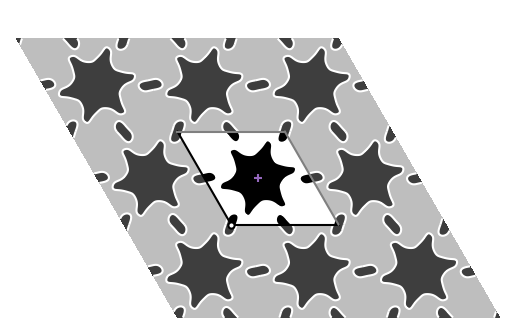

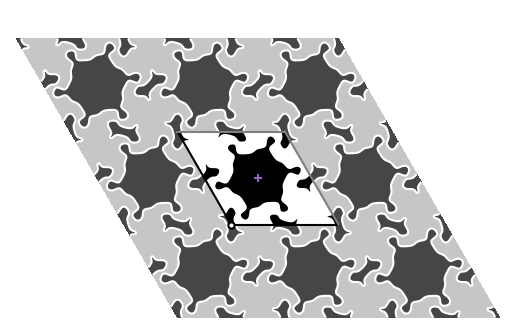

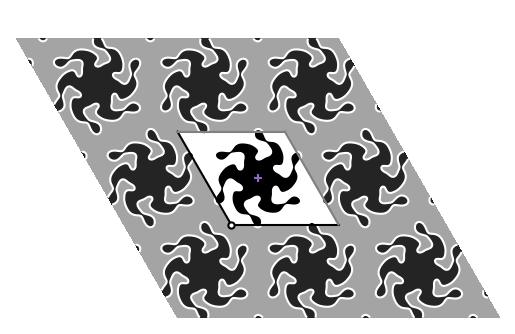

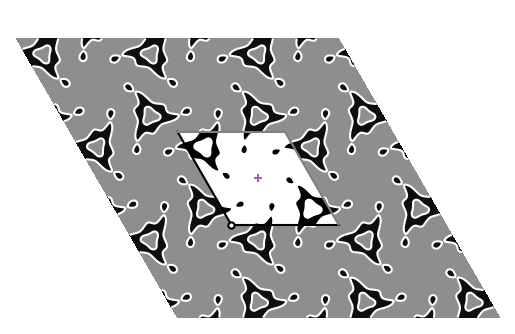

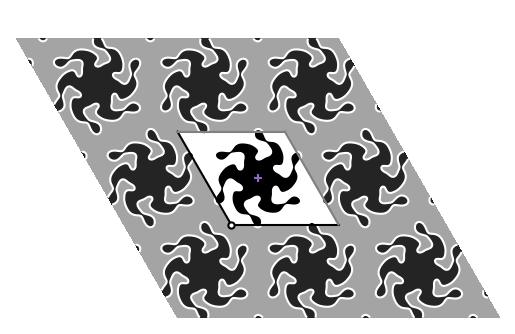

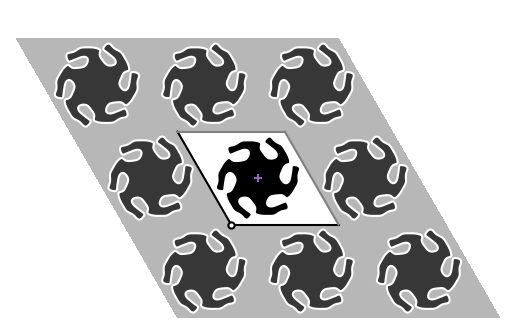

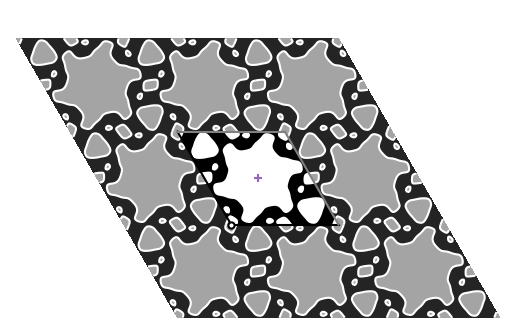

In [24]:
for (i, nodal_point_calcname) in enumerate(nodal_point_calcnames)
    title =
    if i == 1
        "SG 2 Candidates"
    elseif i == 11
        "SG 10 Candidates"
    elseif i == 21
        "SG 16 Candidates"
    else 
        " " 
    end
    plot_lattice_from_mpbparams("./dispersions/input/"*nodal_point_calcname*".sh", repeat=1)
    PyPlot.title(title)
end

In [139]:
for nodal_point_calcname in nodal_point_calcnames
    cp("./dispersions/input/$nodal_point_calcname", "./nodal_points/input/$nodal_point_calcname")
end

In [26]:
#This is the 501x501 kmesh we use for the nodal point calculations
ks = Vector{Vector{Float64}}()
N = 500
for i in 1:N+1
for j in 1:N+1
    kx = (i-1)/N - 0.5
    ky = (j-1)/N - 0.5
    push!(ks, [kx, ky])
end
end
for idx in 1:200
    open("nodal_points/input/kpoints-$idx.sh", "w") do io 
        write(io, "kvecs=(list ")
        for k in ks[idx:200:length(ks)]
            kx, ky = k
            write(io, "(vector3 $(kx) $(ky)) ")
        end
        write(io, ")")
    end
end

dim2-sg2-29481-res64-te
0.0009179999999999744
0.0
dim2-sg2-20482-res64-te
0.0002569999999999517
0.0
dim2-sg2-21585-res64-te
0.0004510000000000347
0.0
dim2-sg2-25798-res64-te
0.0005839999999999734
0.0
dim2-sg2-23907-res64-te
0.0005030000000000312
0.0
dim2-sg2-22469-res64-te
0.0010599999999999499
0.0
dim2-sg2-23318-res64-te
0.0008050000000000002
0.0
dim2-sg2-10482-res64-te
0.0006669999999999732
-2.000000000002e-6
dim2-sg2-28730-res64-te
0.0005359999999999809
0.0
dim2-sg2-19491-res64-te
0.0005850000000000022
0.0
dim2-sg10-4531-res64-te
0.00022100000000002673
0.0
dim2-sg10-15403-res64-te
0.0004210000000000047
-4.000000000004e-6
dim2-sg10-26981-res64-te
0.00020899999999995922
0.0
dim2-sg10-20683-res64-te
0.00020799999999998597
-6.999999999979245e-6
dim2-sg10-13730-res64-te
0.0002809999999999757
0.0
dim2-sg10-27456-res64-te
0.00014799999999998148
-2.000000000002e-6
dim2-sg10-12143-res64-te
0.00015799999999999148
0.0
dim2-sg10-10683-res64-te
0.0002610000000000112
0.0
dim2-sg10-14531-res64-te


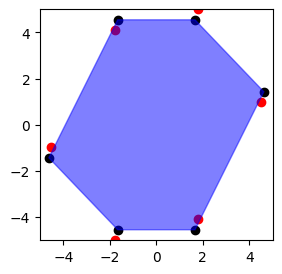

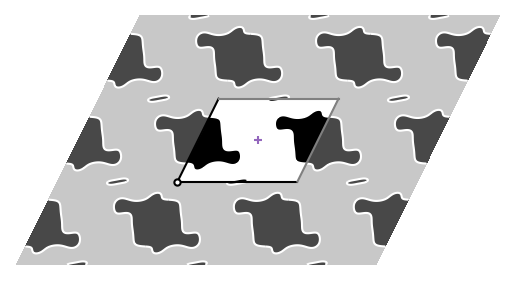

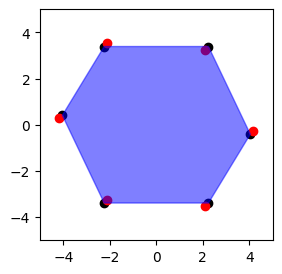

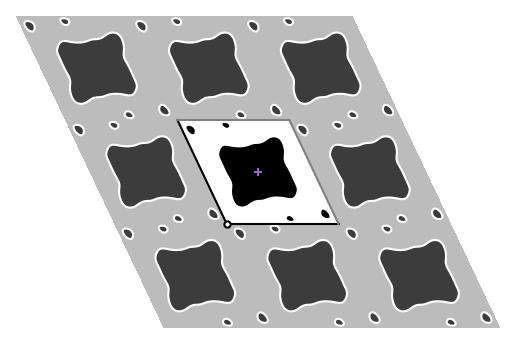

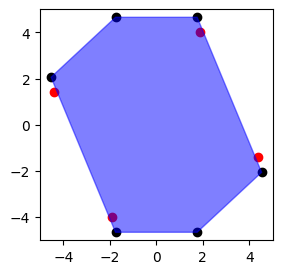

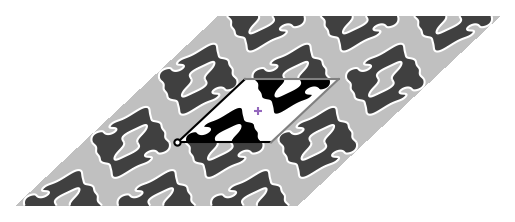

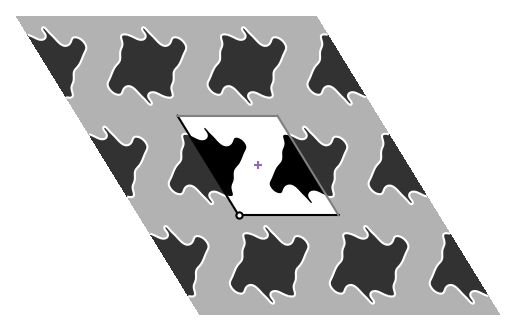

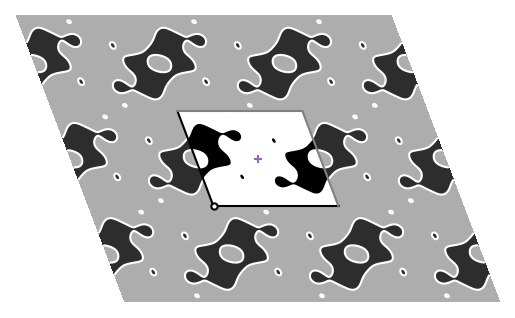

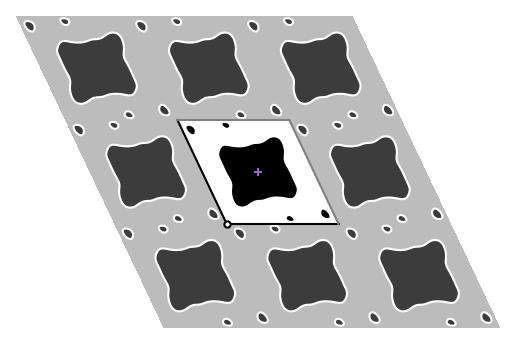

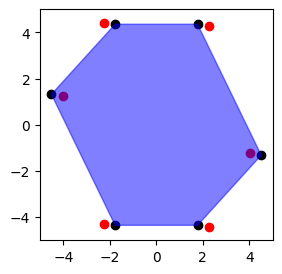

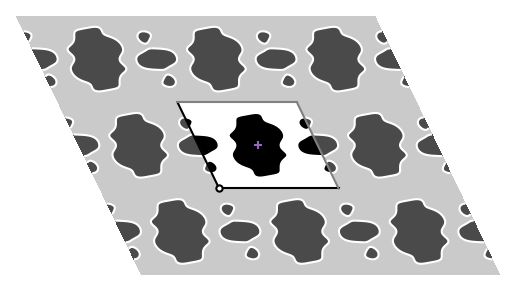

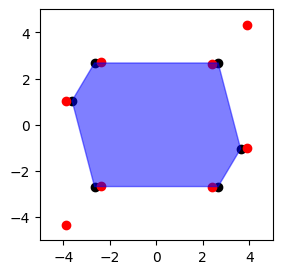

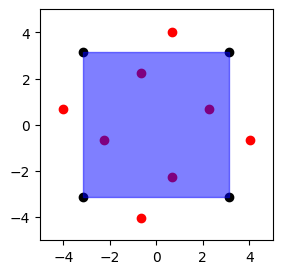

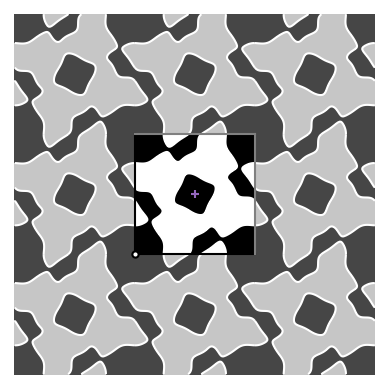

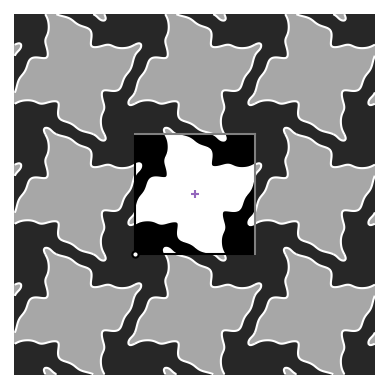

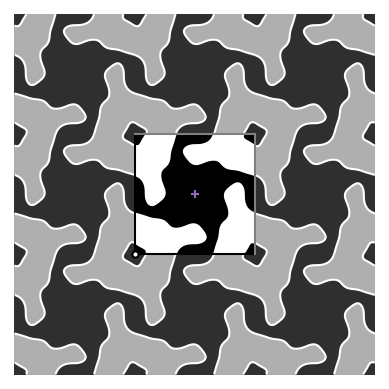

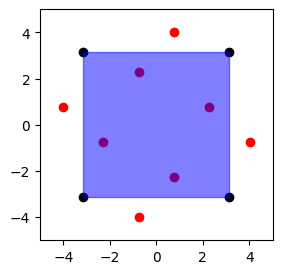

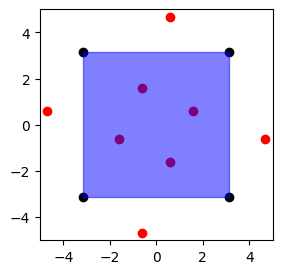

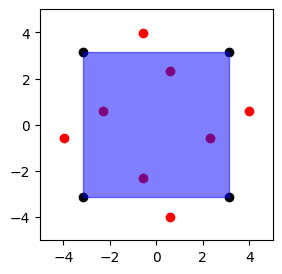

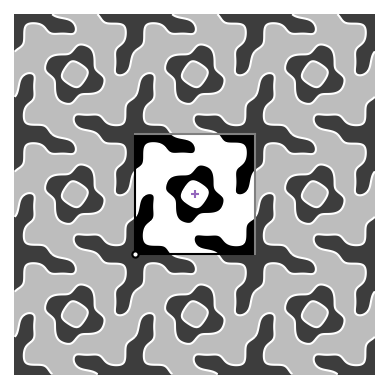

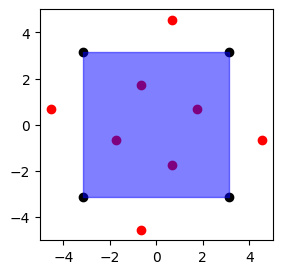

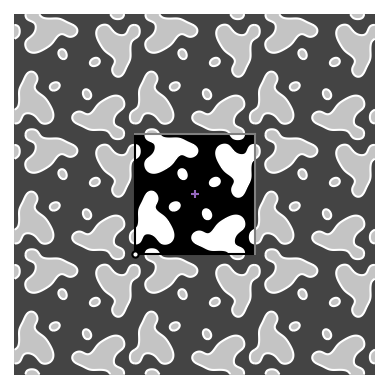

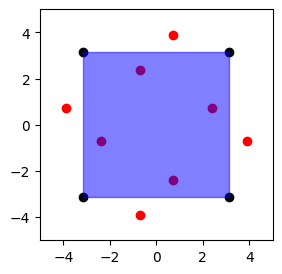

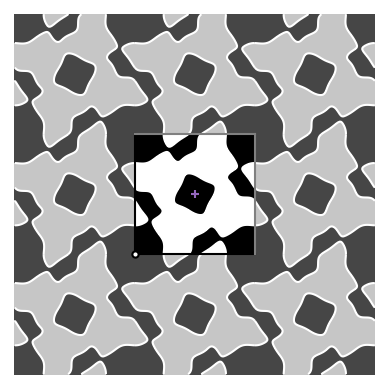

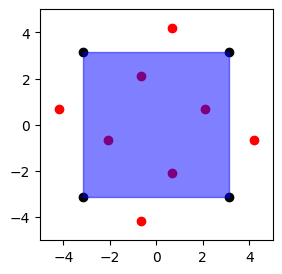

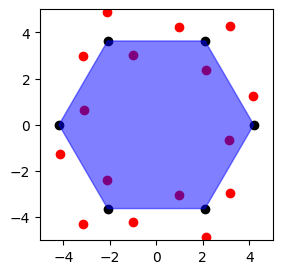

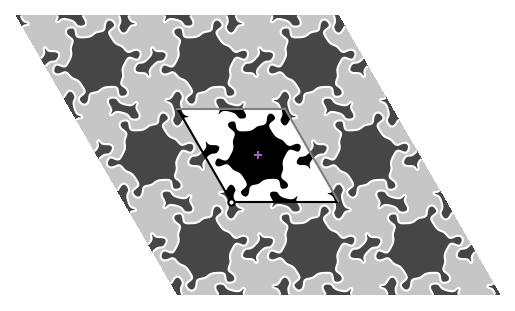

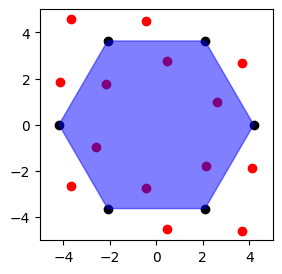

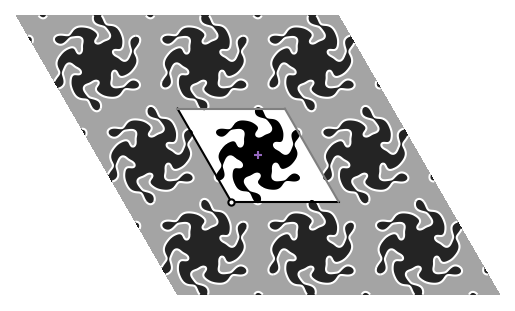

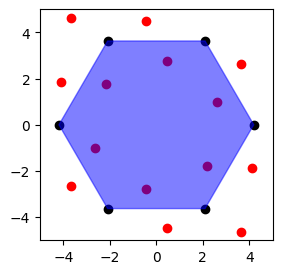

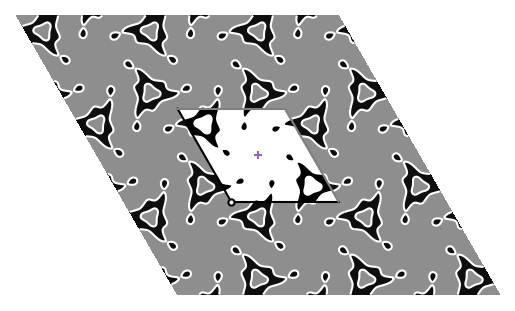

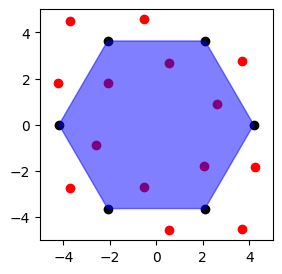

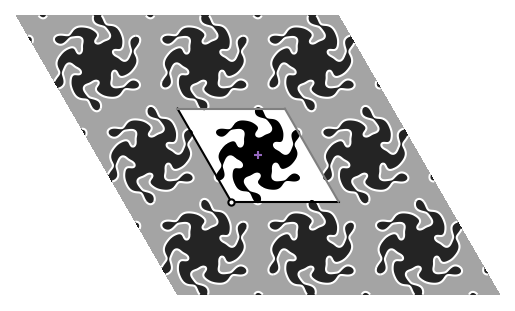

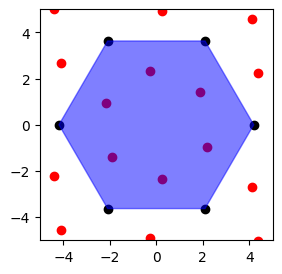

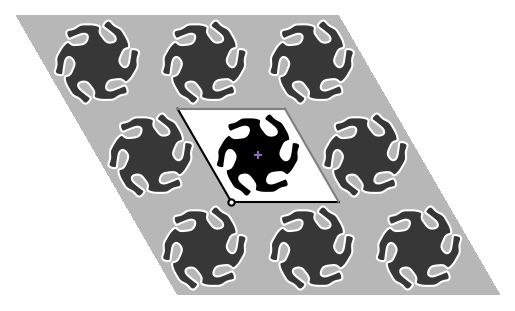

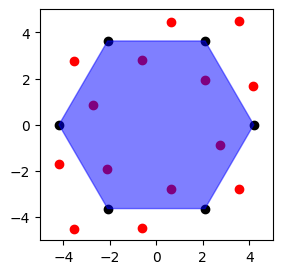

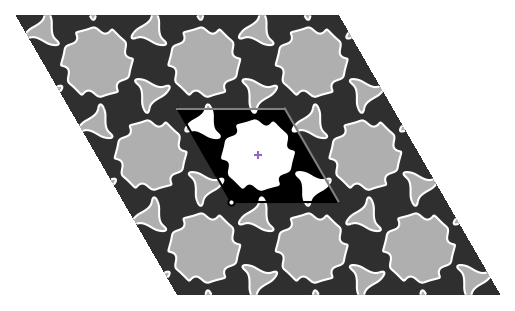

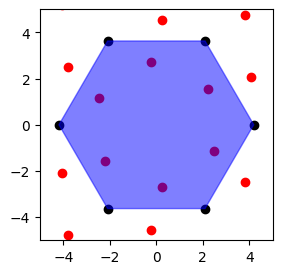

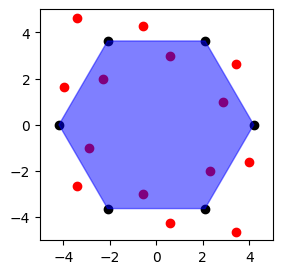

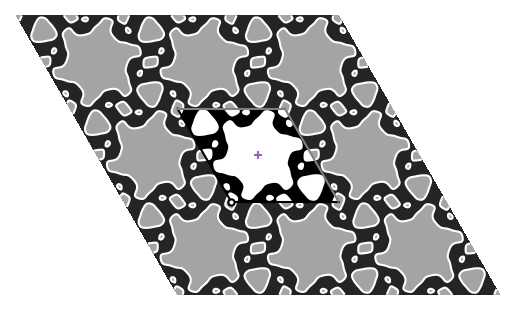

0.00020300000000006424
-0.0003630000000000022


In [64]:
for nodal_point_calcname in nodal_point_calcnames
    println(nodal_point_calcname); flush(stdout)
    num_nodal_points = 
        if MPBUtils.parse_sgnum(nodal_point_calcname) == 2
            2
        elseif MPBUtils.parse_sgnum(nodal_point_calcname) == 10 
            4
        else 
            6
        end
    
    figure(figsize=(3,3))
    top_band = nodal_point_data[nodal_point_calcname][2]
    band1 = zeros(501*501)
    band2 = zeros(501*501)
    all_bands = zeros(501*501, 11)
    for idx in 1:200
        #println("Idx: $idx"); flush(stdout)
        dispersion = readdlm("nodal_points/output/$nodal_point_calcname-$idx-dispersion.out", ',', Float64)
        dispersion = sort(dispersion[:, 6:end], dims = 2)
        lower_dispersion = dispersion[:, top_band]
        upper_dispersion = dispersion[:, top_band+1]
        gap = minimum(upper_dispersion - lower_dispersion)
        gap < 0 && (println("Negative Gap at idx: $idx"); flush(stdout); println(argmin(upper_dispersion - lower_dispersion)))
        band1[idx:200:end] =  lower_dispersion 
        band2[idx:200:end] =  upper_dispersion 
        all_bands[idx:200:end, :] = dispersion
    end
    xs = []
    ys = []
    
    Rs = first(lattice_from_mpbparams("./nodal_points/input/"*nodal_point_calcname*".sh"))
    Gs = reciprocalbasis(Rs)
    verts = wignerseitz(Gs).verts;
    faces = wignerseitz(Gs).faces;
    for vert in verts
        x, y = Gs[1]*vert[1] + Gs[2]*vert[2]
        scatter(x, y, color="black")
        push!(xs, x)
        push!(ys, y)
    end
    fill(xs, ys, alpha=0.5, color="blue")
    xlim(-5, 5)
    ylim(-5, 5)
    theta = 2π/num_nodal_points
    rotation_matrix = [cos(theta) -sin(theta); sin(theta) cos(theta)]
    #nodal_point_locations = ks[sortperm(band2-band1)[1:num_nodal_points]]
    nodal_point_value = band1[argmin(band2 - band1)]
    for idx_1 in -1:1
        for idx_2 in -1:1
            for i in 1:num_nodal_points
                k = (rotation_matrix^i) * wigner_seitz(ks[argmin(band2-band1)] + [idx_1, idx_2], Gs)
                #k in nodal_point_locations
                scatter(k..., color="red")
            end
            #X = [k[1] for k in wigner_seitz.([k + [idx_1, idx_2] for k in ks], Ref(Gs))]
            #Y = [k[2] for k in wigner_seitz.([k + [idx_1, idx_2] for k in ks], Ref(Gs))]
            #X = reshape(X, (501, 501))
            #Y = reshape(Y, (501, 501));
            #contour(X, Y, reshape(log.(band2 .- nodal_point_value), (501, 501)), 0, cmap="hot")
        end
    end
    println(minimum(band2) - nodal_point_value)
    println(-maximum(band1) + nodal_point_value)

    #=figure(figsize=(3,3))
    imshow(reshape(log.(band2 .- nodal_point_value), (501, 501)))
    figure(figsize=(3,3))
    imshow(reshape(log.(nodal_point_value .- band1), (501, 501)))
=#
    plot_lattice_from_mpbparams("./dispersions/input/"*nodal_point_calcname*".sh", repeat=1)
end

In [44]:
sortperm([1, 3, 2])

3-element Vector{Int64}:
 1
 3
 2

In [84]:
nodal_point = band1[argmin(band2-band1)]

0.663105

In [196]:
theta = π/3
[cos(theta) -sin(theta); sin(theta) cos(theta)]*[-0.09179869280115048, -0.409]

2-element Vector{Float64}:
 0.09179869280115054
 0.409

In [197]:
sortperm(band2-band1)

251001-element Vector{Float64}:
 5.699999999997374e-5
 5.699999999997374e-5
 6.20000000000065e-5
 8.000000000008001e-5
 0.00019999999999997797
 0.00019999999999997797
 0.0003009999999999957
 0.0003009999999999957
 0.00032799999999999496
 0.0003289999999999127
 0.0003529999999999367
 0.0003529999999999367
 0.00039999999999995595
 ⋮
 0.079488
 0.07949099999999998
 0.07949099999999998
 0.07949099999999998
 0.07949099999999998
 0.07949200000000001
 0.07949200000000001
 0.07949600000000001
 0.07949600000000001
 0.07949600000000001
 0.07949600000000001
 0.07952500000000007

In [193]:
wigner_seitz.(ks[sortperm(band2-band1)])

251001-element Vector{Vector{Float64}}:
 [-0.09179869280115048, -0.409]
 [0.09179869280115048, 0.409]
 [0.4001037365484106, 0.125]
 [-0.40010373654841064, -0.12500000000000003]
 [-0.30830504374726014, 0.284]
 [0.30830504374726014, -0.28400000000000003]
 [-0.31003709455482903, 0.283]
 [0.31003709455482903, -0.28300000000000003]
 [0.30830504374726014, -0.28200000000000003]
 [-0.30830504374726014, 0.282]
 [-0.39837168574084175, -0.12600000000000003]
 [0.3983716857408417, 0.126]
 [-0.09353074360871935, -0.41]
 ⋮
 [0.0034641016151377574, -0.0020000000000000018]
 [-0.0017320508075688787, 0.0050000000000000044]
 [0.0, -0.0020000000000000018]
 [0.0, 0.0020000000000000018]
 [0.0017320508075688787, -0.0050000000000000044]
 [-0.0017320508075688787, 0.0010000000000000009]
 [0.0017320508075688787, -0.0010000000000000009]
 [-0.0034641016151377574, 0.0040000000000000036]
 [-0.0017320508075688787, 0.0030000000000000027]
 [0.0017320508075688787, -0.0030000000000000027]
 [0.0034641016151377574, -0.00400

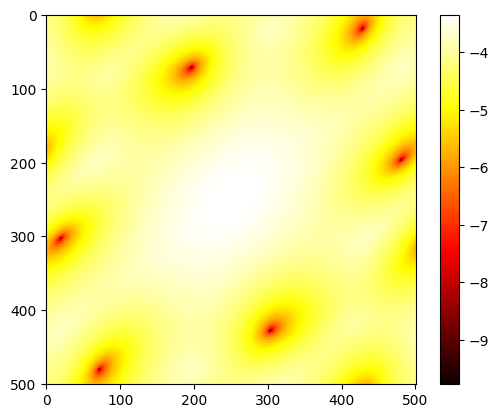

PyObject <matplotlib.colorbar.Colorbar object at 0x7f1e6d6ccca0>

In [185]:
imshow(log.(reshape(band2, (501, 501)) .- nodal_point), interpolation="none", cmap="hot")
colorbar()

In [116]:
count(x -> x < nodal_point, band2)

0

In [139]:
ion()

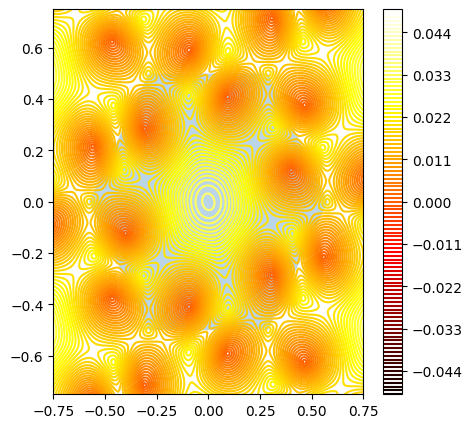

PyObject <matplotlib.colorbar.Colorbar object at 0x7f1ea0089730>

In [114]:
levels = -0.05:0.001:0.05
figure(figsize=(5,5))
for idx_1 in -1:1
    for idx_2 in -1:1
        X = [k[1] for k in wigner_seitz.([k + [idx_1, idx_2] for k in ks])]
        Y = [k[2] for k in wigner_seitz.([k + [idx_1, idx_2] for k in ks])]
        X = reshape(X, (501, 501))
        Y = reshape(Y, (501, 501));
        contour(X, Y, reshape(band2 .- nodal_point, (501, 501)), 5, cmap="hot", levels = levels)

        #contour(X, Y, reshape(band2 .- nodal_point, (501, 501)), 4, cmap="hot", levels = levels)
    end
end
xs = []
ys = []

for vert in verts
    x, y = Gs[1]*vert[1] + Gs[2]*vert[2]
    x *= 1/7.255197456936871
    y *= 1/7.255197456936871
    push!(xs, x)
    push!(ys, y)
    #scatter(x, y, s=20, color="black")
end
fill(xs, ys, alpha=0.3)


xlim(-0.75, 0.75)
ylim(-0.75, 0.75)
colorbar()

In [101]:
?contour

search: contour contourf contour3D contourf3D tricontour tricontourf




        Plot contours.

        Call signature::

            contour([X, Y,] Z, [levels], **kwargs)

        `.contour` and `.contourf` draw contour lines and filled contours,
        respectively.  Except as noted, function signatures and return values
        are the same for both versions.

        Parameters
        ----------
        X, Y : array-like, optional
            The coordinates of the values in *Z*.

            *X* and *Y* must both be 2-D with the same shape as *Z* (e.g.
            created via `numpy.meshgrid`), or they must both be 1-D such
            that ``len(X) == M`` is the number of columns in *Z* and
            ``len(Y) == N`` is the number of rows in *Z*.

            If not given, they are assumed to be integer indices, i.e.
            ``X = range(M)``, ``Y = range(N)``.

        Z : array-like(N, M)
            The height values over which the contour is drawn.

        levels : int or array-like, optional
            Determines the number and positio

In [192]:
b2 = [0, 1]
b1 = [sqrt(3)/2, 1/2]
kbasis = hcat(b1, b2)
function wigner_seitz(k::Vector{<:Real})
    return kbasis*k
end

wigner_seitz (generic function with 1 method)

In [73]:
Rs = ([1.0, 0.0], [-0.5, sqrt(3)/2]) # direct basis for space group 147
Gs = reciprocalbasis(Rs)
verts = wignerseitz(Gs).verts;
faces = wignerseitz(Gs).faces;

In [74]:
figure(figsize=(3, 3))
for vert in verts
    x, y = Gs[1]*vert[1] + Gs[2]*vert[2]
    scatter(x, y)
    push!(xs, x)
    push!(ys, y)
end
fill(xs, ys, alpha=0.5)
xlim(-5, 5)
ylim(-5, 5)

LoadError: UndefVarError: xs not defined

In [148]:
nodal_point_locations = sortperm(band2-band1)[1:6]

6-element Vector{Int64}:
  98770
 152232
 241179
   9823
  36554
 214448

In [166]:
?contour

search: contour contourf contour3D contourf3D tricontour tricontourf




        Plot contours.

        Call signature::

            contour([X, Y,] Z, [levels], **kwargs)

        `.contour` and `.contourf` draw contour lines and filled contours,
        respectively.  Except as noted, function signatures and return values
        are the same for both versions.

        Parameters
        ----------
        X, Y : array-like, optional
            The coordinates of the values in *Z*.

            *X* and *Y* must both be 2-D with the same shape as *Z* (e.g.
            created via `numpy.meshgrid`), or they must both be 1-D such
            that ``len(X) == M`` is the number of columns in *Z* and
            ``len(Y) == N`` is the number of rows in *Z*.

            If not given, they are assumed to be integer indices, i.e.
            ``X = range(M)``, ``Y = range(N)``.

        Z : array-like(N, M)
            The height values over which the contour is drawn.

        levels : int or array-like, optional
            Determines the number and positio

In [173]:
figure(figsize=(5, 5))

levels = [nodal_point]

for idx_1 in -1:1
    for idx_2 in -1:1
        X = [k[1] for k in wigner_seitz.([k + [idx_1, idx_2] for k in ks])]
        Y = [k[2] for k in wigner_seitz.([k + [idx_1, idx_2] for k in ks])]
        X = reshape(X, (501, 501))
        Y = reshape(Y, (501, 501));
        for nodal_point_location in nodal_point_locations
            scatter(X[nodal_point_location], Y[nodal_point_location], s=20, color="black")
        end
        contour(X, Y, reshape(band2 .- nodal_point, (501, 501)), levels=[-0.002, -0.01, 0, 0.01, 0.02], cmap="hot")
        #contour(X, Y, reshape(band1 .- nodal_point, (501, 501)), 10, cmap="hot")
    
    end
end
colorbar()

xs = []
ys = []

for vert in verts
    x, y = Gs[1]*vert[1] + Gs[2]*vert[2]
    x *= 1/7.255197456936871
    y *= 1/7.255197456936871
    push!(xs, x)
    push!(ys, y)
    #scatter(x, y, s=20, color="black")
end
fill(xs, ys, alpha=0.3)

xlim(-0.75, 0.75)
ylim(-0.75, 0.75)

savefig("NodalPoints-sg16.pdf")

In [38]:
bands = readdlm("nodal_points/output/dim2-sg16-52-res64-te-dispersion.out", ',')[:, (1:2) .+ 5];

ks[sortperm(bands[:, 2] .- bands[:, 1])]
#println(minimum(bands[:, 2] .- bands[:, 1]))

2601-element Vector{Vector{Float64}}:
 [-0.28, -0.36]
 [-0.28400000000000003, -0.358]
 [-0.28200000000000003, -0.36]
 [-0.28200000000000003, -0.358]
 [-0.278, -0.362]
 [-0.278, -0.36]
 [-0.28600000000000003, -0.358]
 [-0.28600000000000003, -0.356]
 [-0.276, -0.362]
 [-0.28800000000000003, -0.356]
 [-0.28, -0.362]
 [-0.28400000000000003, -0.36]
 [-0.28, -0.358]
 ⋮
 [-0.24000000000000002, -0.31]
 [-0.23600000000000004, -0.312]
 [-0.23200000000000004, -0.314]
 [-0.23800000000000002, -0.31]
 [-0.23400000000000004, -0.312]
 [-0.23000000000000004, -0.314]
 [-0.23600000000000004, -0.31]
 [-0.23200000000000004, -0.312]
 [-0.23400000000000004, -0.31]
 [-0.23000000000000004, -0.312]
 [-0.23200000000000004, -0.31]
 [-0.23000000000000004, -0.31]

In [37]:
# For cases where we need a lot of kpoints, mpi will not allow a large file to be parsed, so we must give the kpoints 
# as a string to be parsed by guile. 
ks = Vector{Vector{Float64}}()
N = 11
open("nodal_points/input/kpoints.sh", "w") do io 
    write(io, "(list ")
    for i in 1:N+1
    for j in 1:N+1
        kx = (i-1)/N - 0.5
        ky = (j-1)/N - 0.5
        write(io, "(list $(kx) $(ky)) \n")
        push!(ks, [kx, ky])
    end
    end
    #write(io, ")")
end

In [271]:
sg = 11
mode = "te"
id_eps = 1
dir = "./nodal_points/output/"
epsilon = []
epsilon = h5open(dir*"dim2-sg11-1-res64-te-epsilon.h5", "r") do fid
    read(fid, "data")
end;

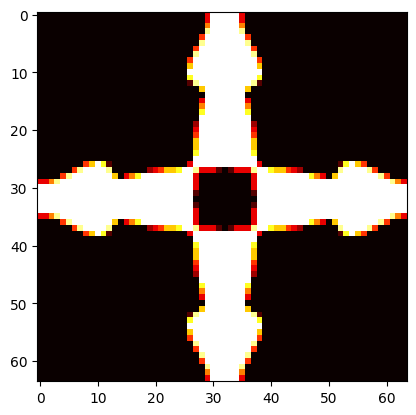

PyObject <matplotlib.image.AxesImage object at 0x7f61308467f0>

In [273]:
imshow(epsilon, cmap="hot")

In [265]:
i = 1
j = 1
filename = "dim2-sg11-$(j+10000*(i-1))-res64-te-dispersion.out"
bands = readdlm("./nodal_points/output/$(filename)", ',')[:, 6:end]
bands2 = bands[:,1]
bands2_reshaped = reshape(bands2, (51, 51));
imshow(abs.(bands2_reshaped .- np.flip(bands2_reshaped, axis=(0))), cmap="hot")
colorbar()
xticks([])
yticks([])


(Any[], Any[])

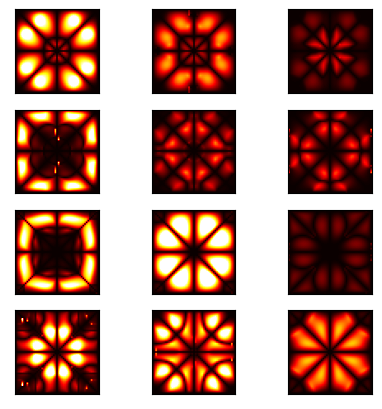

In [249]:
figure(figsize=(5, 5))
for j in 1:4
for i in 1:3
    subplot(4, 3, (j-1)*3+i)
    filename = "dim2-sg10-$(j+10000*(i-1))-res64-tm-dispersion.out"
    bands = readdlm("./nodal_points/output/$(filename)", ',')[:, 6:end]
    bands2 = bands[:,40]
    bands2_reshaped = reshape(bands2, (51, 51));
    imshow(abs.(bands2_reshaped .- np.flip(bands2_reshaped, axis=(0))), cmap="hot", vmin=0, vmax=1e-2)
    xticks([])
    yticks([])
    #cbar =  colorbar(fraction=0.045, ticks=([0, 5e-6]))
    #cbar.ax.tick_params(labelsize=5) 
end
end

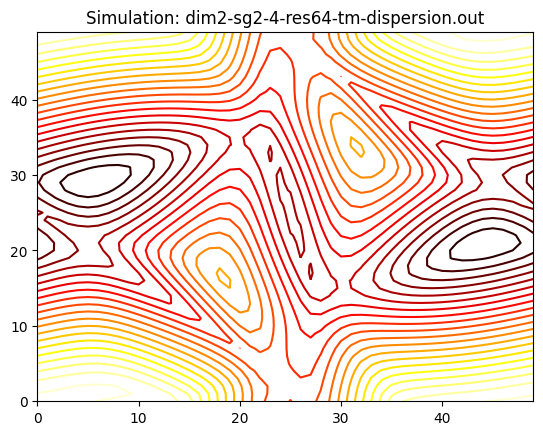

PyObject <matplotlib.contour.QuadContourSet object at 0x7f9631029d90>

In [128]:
filename = "dim2-sg2-4-res64-tm-dispersion.out"

bands = readdlm("./nodal_points/output/$(filename)", ',')[:, 6:end]
bands2 = bands[:, 5]
bands2_reshaped = reshape(bands2, (50, 50));
title("Simulation: $(filename)")
contour(bands2_reshaped, 20, cmap="hot", interpolation="gaussian")


In [3]:
JLD2_DATA = Dict{Tuple{Integer, Integer, String}, Dict{String, Any}}()
sg = 10
for mode in ["te", "tm"]
    println("Analyzing mode: $mode\n")
    flush(stdout)
    for id_eps in 1:3
        println("Analyzing id_eps : ", id_eps)
        flush(stdout)
        dir = "./symeigs/output/sg$(sg)/eps$(id_eps)/$(mode)/"
        filename = dir*"sg$(sg)-epsid$(id_eps)-res64-$(mode).jld2"
        loaded_data = load(filename)
        JLD2_DATA[(sg, id_eps, mode)] = loaded_data
    end
end


Analyzing mode: te

Analyzing id_eps : 1
Analyzing id_eps : 2
Analyzing id_eps : 3
Analyzing mode: tm

Analyzing id_eps : 1
Analyzing id_eps : 2
Analyzing id_eps : 3


In [16]:
cumsummariesv = JLD2_DATA[10, 3, "tm"]["cumsummariesv"];

In [17]:
cumsummariesv[9588]

23-element Vector{BandSummary}:
 1-band (nontrivial): [X₁, M₂, Γ₁]
 2-band (trivial): [X₁+X₂, M₁+M₂, 2Γ₁]
 4-band (trivial): [X₁+3X₂, M₁+M₂+M₃M₄, 2Γ₁+Γ₃Γ₄]
 5-band (trivial): [2X₁+3X₂, M₁+2M₂+M₃M₄, 2Γ₁+Γ₂+Γ₃Γ₄]
 7-band (trivial): [3X₁+4X₂, M₁+2M₂+2M₃M₄, 3Γ₁+2Γ₂+Γ₃Γ₄]
 10-band (nontrivial): [5X₁+5X₂, 2M₁+2M₂+3M₃M₄, 4Γ₁+2Γ₂+2Γ₃Γ₄]
 12-band (nontrivial): [6X₁+6X₂, 3M₁+3M₂+3M₃M₄, 4Γ₁+2Γ₂+3Γ₃Γ₄]
 15-band (trivial): [8X₁+7X₂, 3M₁+4M₂+4M₃M₄, 4Γ₁+3Γ₂+4Γ₃Γ₄]
 16-band (trivial): [8X₁+8X₂, 4M₁+4M₂+4M₃M₄, 4Γ₁+4Γ₂+4Γ₃Γ₄]
 18-band (trivial): [9X₁+9X₂, 4M₁+4M₂+5M₃M₄, 5Γ₁+5Γ₂+4Γ₃Γ₄]
 20-band (trivial): [10X₁+10X₂, 5M₁+5M₂+5M₃M₄, 5Γ₁+5Γ₂+5Γ₃Γ₄]
 21-band (trivial): [10X₁+11X₂, 5M₁+6M₂+5M₃M₄, 6Γ₁+5Γ₂+5Γ₃Γ₄]
 24-band (trivial): [12X₁+12X₂, 6M₁+6M₂+6M₃M₄, 6Γ₁+6Γ₂+6Γ₃Γ₄]
 25-band (nontrivial): [12X₁+13X₂, 7M₁+6M₂+6M₃M₄, 7Γ₁+6Γ₂+6Γ₃Γ₄]
 26-band (nontrivial): [13X₁+13X₂, 7M₁+7M₂+6M₃M₄, 7Γ₁+7Γ₂+6Γ₃Γ₄]
 28-band (trivial): [14X₁+14X₂, 7M₁+7M₂+7M₃M₄, 7Γ₁+7Γ₂+7Γ₃Γ₄]
 30-band (nontrivial): [14X₁+16X₂, 8M₁+8M₂+7M₃M₄

In [71]:
# Below we find candidates that are topological and without corner charge or polarization

In [11]:
usable_ids = Int[]
for (i, cumsummary) in enumerate(cumsummariesv)
    i % 1000 == 0 && println("Iteration: $i");
    flush(stdout)
    length(cumsummary) >= 1 || continue
    
    band_summary = cumsummary[1]

    band_summary.topology == NONTRIVIAL || continue
    band_summary.n[end] < 2 || continue

    push!(usable_ids, i)
end

Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000


In [14]:
usable_ids

14-element Vector{Int64}:
  392
  742
  795
 1512
 1931
 2164
 2536
 3747
 4106
 4544
 5162
 5718
 7986
 9588

In [84]:
dim_ten_sims = filter(x -> contains(x, "sg10"), readdir("./nodal_points/output"))
dim_two_sims = filter(x -> contains(x, "sg2"), readdir("./nodal_points/output"))

3-element Vector{String}:
 "dim2-sg2-4-res64-tm-dispersion.out"
 "dim2-sg2-5-res64-tm-dispersion.out"
 "dim2-sg2-8-res64-tm-dispersion.out"

In [90]:
dim_ten_sims

9-element Vector{String}:
 "dim2-sg10-1-res64-te-dispersion.out"
 "dim2-sg10-20001-res64-te-dispersion.out"
 "dim2-sg10-20004-res64-te-dispersion.out"
 "dim2-sg10-28798-res64-tm-dispersion.out"
 "dim2-sg10-29588-res64-tm-dispersion.out"
 "dim2-sg10-29948-res64-te-dispersion.out"
 "dim2-sg10-392-res64-tm-dispersion.out"
 "dim2-sg10-4544-res64-tm-dispersion.out"
 "dim2-sg10-7986-res64-tm-dispersion.out"

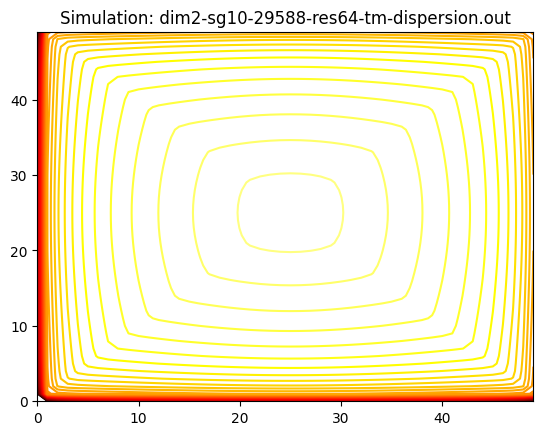

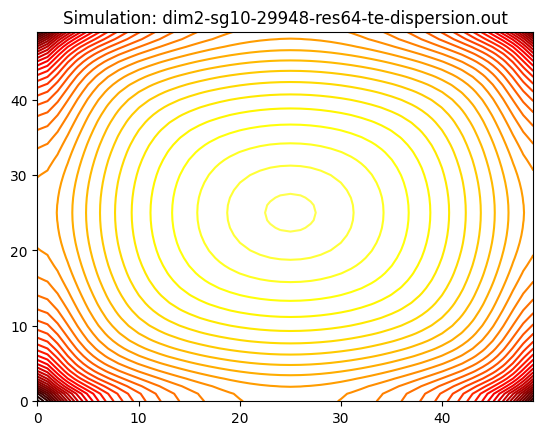

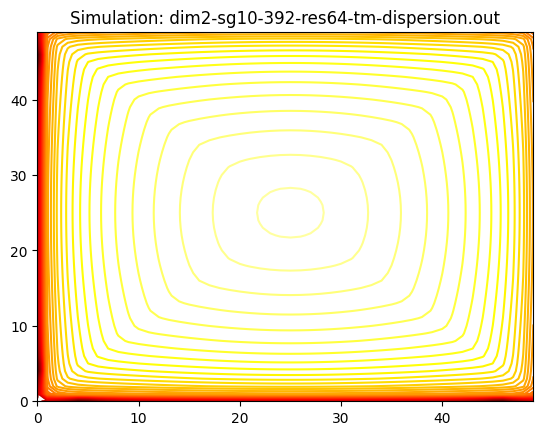

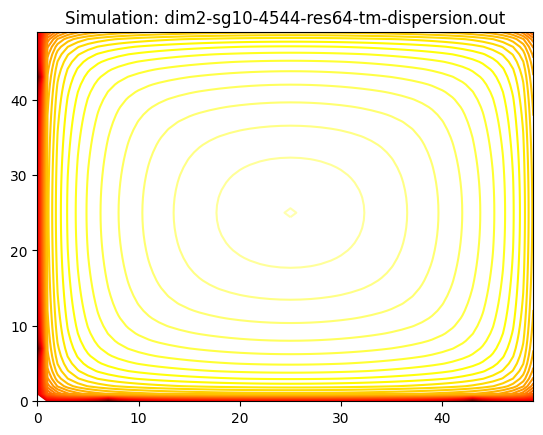

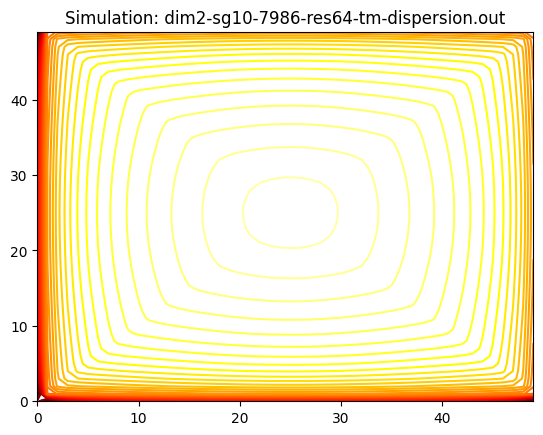

dim2-sg10-28798-res64-tm-dispersion.out


In [95]:
for filename in dim_ten_sims
    try 
        figure()
    bands = readdlm("./nodal_points/output/$(filename)", ',')[:, 6:end]
    bands1 = bands[:, 1]
    bands2 = bands[:, 2]
    bands1_reshaped = reshape(bands1, (50, 50))
    bands2_reshaped = reshape(bands2, (50, 50));
    title("Simulation: $(filename)")
    contour(log.(np.roll(bands2_reshaped - bands1_reshaped, (0,0), axis=(0, 1))), 50, cmap="hot", interpolation="gaussian", vmax=log(1))
    catch
        println(filename)
    end
end

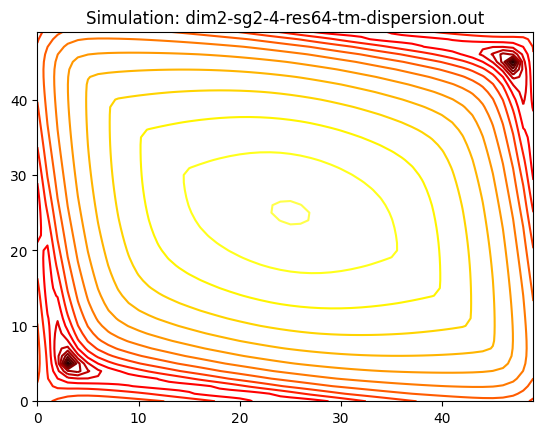

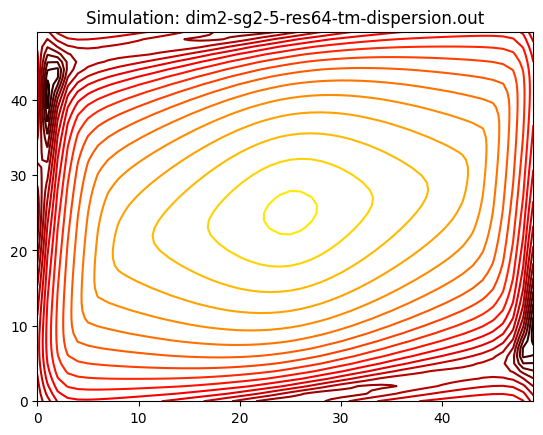

In [98]:
for filename in dim_two_sims
    figure()
    bands = readdlm("./nodal_points/output/$(filename)", ',')[:, 6:end]
    bands1 = bands[:, 1]
    bands2 = bands[:, 2]
    bands1_reshaped = reshape(bands1, (50, 50))
    bands2_reshaped = reshape(bands2, (50, 50));
    title("Simulation: $(filename)")
    contour(log.(np.roll(bands2_reshaped - bands1_reshaped, (0,0), axis=(0, 1))), 20, cmap="hot", interpolation="gaussian", vmax=log(1))
end

In [77]:
minimum(bands2 - bands1)

0.0013859999999999983

In [78]:
# Find the nodal points:
ks[sortperm(bands2 - bands1)][1:4]

4-element Vector{Vector{Float64}}:
 [-0.5, -0.4]
 [-0.4, -0.5]
 [-0.5, 0.4]
 [0.4, -0.5]

In [80]:
imshow(log.(np.roll(bands2_reshaped - bands1_reshaped, (0,0), axis=(0, 1))), cmap="hot", interpolation="gaussian"
, vmax=log(1))

PyObject <matplotlib.image.AxesImage object at 0x7f962d775880>

In [97]:
bands = readdlm("./nodal_points/output/dim2-sg10-20004-res64-te-dispersion.out", ',')[:, 6:end]
bands1 = bands[:, 1]
bands2 = bands[:, 2]
bands1_reshaped = reshape(bands1, (50, 50))
bands2_reshaped = reshape(bands2, (50, 50));

In [109]:
ks[sortperm(bands2 - bands1)][1:4]

4-element Vector{Vector{Float64}}:
 [-0.5, -0.48]
 [-0.5, 0.48]
 [-0.48, -0.5]
 [0.48, -0.5]

In [ ]:
usable_ids = Int[]
for (i, cumsummary) in enumerate(cumsummariesv)
    i % 1000 == 0 && println("Iteration: $i");
    flush(stdout)
    length(cumsummary) >= 1 || continue
    first_band_corner = corners(cumsummary[1], wyckoffs(10, 2)[end])
    first_band_polarization = polarizations(cumsummary[1], wyckoffs(10, 2)[end])

    cumsummariesv[1][1].topology == TRIVIAL || continue
    (cumsummary[1].n)[end] < 2 || continue
    (first_band_corner != 0 && first_band_polarization ≈ zeros(2)) && push!(usable_ids, i)
end

In [184]:
usable_ids = Int[]
for (i, cumsummary) in enumerate(cumsummariesv)
    i % 1000 == 0 && println("Iteration: $i");
    flush(stdout)
    length(cumsummary) >= 1 || continue
    first_band_corner = corners(cumsummary[1], wyckoffs(10, 2)[end])
    first_band_polarization = polarizations(cumsummary[1], wyckoffs(10, 2)[end])

    cumsummariesv[1][1].topology == TRIVIAL || continue
    (cumsummary[1].n)[end] < 2 || continue
    (first_band_corner != 0 && first_band_polarization ≈ zeros(2)) && push!(usable_ids, i)
end

Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000


In [168]:
usable_ids

1518-element Vector{Int64}:
    1
    4
   10
   28
   29
   30
   33
   34
   36
   44
   46
   55
   58
    ⋮
 9914
 9915
 9917
 9928
 9936
 9950
 9953
 9969
 9975
 9980
 9981
 9985

In [167]:
[x[1] for x in cumsummariesv[usable_ids]]

1518-element Vector{BandSummary}:
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 ⋮
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 1-band (nontrivial): [X₁, M₂, Γ₁]

In [134]:
for id in usable_ids
    real_id = id + Int(2e4)
    band_data = readdlm("./symeigs/output/sg10/eps3/tm/dim2-sg10-$(real_id)-res64-tm-dispersion.out", ',')[:, 6:end]
    band1_data = band_data[:, 1]
    band2_data = band_data[:, 2]
    println((maximum(band1_data) - minimum(band2_data))/maximum(band1_data))
end

0.2670788607129
0.17807031169100135
0.2576058310192497
0.2526397103198552
0.27734646956915954
0.2495727097241213
0.24854129636212813
0.23965094785711213
0.2736164570841343
0.26052337046314544
0.2349363570712274
0.2638101173316356
0.17145876862222573
0.2715724989874443
0.2805076798868703
0.2501144325904017
0.2584139150749928
0.2462506086674241
0.2869301915309581
0.2826271676445893


In [121]:
.05/.2

0.25

In [105]:
lgirreps(10, 2)

Dict{String, Vector{LGIrrep{2}}} with 4 entries:
  "X" => [LGIrrep{2}("X₁", [1, 2] ([0, 1/2]), Matrix{ComplexF64}[[1.0+0…
  "M" => [LGIrrep{2}("M₁", [1, 2, 4⁺, 4⁻] ([1/2, 1/2]), Matrix{ComplexF…
  "Γ" => [LGIrrep{2}("Γ₁", [1, 2, 4⁺, 4⁻] ([0, 0]), Matrix{ComplexF64}[…
  "Ω" => [LGIrrep{2}("Ω₁", [1] ([α, β]), Matrix{ComplexF64}[[1.0+0.0im;…

In [135]:
usable_ids .+ 20000

20-element Vector{Int64}:
 20654
 20795
 22164
 22391
 22415
 22585
 22724
 22885
 23265
 23572
 24247
 24543
 25718
 26299
 26702
 27057
 27986
 28090
 28798
 29588

In [90]:
usable_ids_no_corner = Int[]
for (i, cumsummary) in enumerate(cumsummariesv)
    i % 1000 == 0 && println("Iteration: $i");
    flush(stdout)
    length(cumsummary) >= 1 || continue
    first_band_corner = corners(cumsummary[1], wyckoffs(10, 2)[end])
    first_band_polarization = polarizations(cumsummary[1], wyckoffs(10, 2)[end])

    cumsummariesv[1][1].topology == TRIVIAL || continue
    (cumsummariesv[1][1].n)[end] < 2 || continue
    (first_band_corner ≈ 0 && first_band_polarization ≈ zeros(2)) && push!(usable_ids_no_corner, i)
end

Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000


In [91]:
usable_ids_no_corner

4121-element Vector{Int64}:
    6
    7
    9
   11
   13
   15
   17
   18
   19
   20
   24
   38
   39
    ⋮
 9973
 9976
 9982
 9983
 9984
 9986
 9988
 9990
 9992
 9994
 9997
 9998

In [40]:
usable_ids = Int[]
for (i, cumsummary) in enumerate(cumsummariesv)
    i % 1000 == 0 && println("Iteration: $i");
    flush(stdout)
    first_band_corner = corners(cumsummary[1], wyckoffs(10, 2)[end-1])
    first_band_polarization = polarizations(cumsummary[1], wyckoffs(10, 2)[end-1])
    i % 1000 == 0 && println(first_band_corner)
    i % 1000 == 0 && println(first_band_polarization)

    (first_band_corner != 0 && first_band_polarization == 0) && push!(usable_ids, i)
end

Iteration: 1000
0.0
[0.5, 0.5]
Iteration: 2000
0.0
[0.0, 0.0]
Iteration: 3000
0.25
[0.5, 0.5]
Iteration: 4000
0.0
[0.5, 0.5]
Iteration: 5000
0.25
[0.5, 0.5]
Iteration: 6000
0.0
[0.5, 0.5]
Iteration: 7000
0.25
[0.5, 0.5]
Iteration: 8000
0.25
[0.5, 0.5]
Iteration: 9000
0.25
[0.5, 0.5]
Iteration: 10000
0.0
[0.5, 0.5]


1

In [170]:
bands = readdlm("./nodal_points/output/dim2-sg10-28798-res64-tm-dispersion.out", ',')[:, 6:end]
bands1_reshaped = reshape(bands[:, 1], (30, 30))
bands2_reshaped = reshape(bands[:, 2], (30, 30))

30×30 Matrix{Float64}:
 0.193859  0.188463  0.182435  0.176634  …  0.176634  0.182435  0.188463
 0.188463  0.194285  0.189277  0.183718     0.183727  0.189286  0.194285
 0.182435  0.189286  0.195558  0.191027     0.191041  0.195558  0.189277
 0.176634  0.183727  0.191041  0.197662     0.197662  0.191027  0.183718
 0.171108  0.17843   0.185987  0.193641     0.19362   0.185973  0.178422
 0.16589   0.173441  0.181221  0.189102  …  0.189083  0.181209  0.173433
 0.161016  0.168792  0.176788  0.184874     0.184857  0.176777  0.168785
 0.15652   0.164515  0.172719  0.180997     0.180982  0.172709  0.164509
 0.152438  0.160644  0.169042  0.1775       0.177488  0.169034  0.160638
 0.148807  0.157208  0.165787  0.17441      0.174399  0.16578   0.157203
 0.145661  0.154239  0.162979  0.171749  …  0.17174   0.162974  0.154235
 0.143033  0.151765  0.160644  0.169539     0.169532  0.16064   0.151762
 0.140955  0.149811  0.158803  0.167799     0.167794  0.1588    0.149809
 ⋮                          

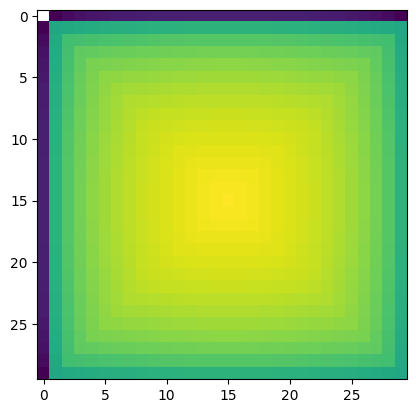

PyObject <matplotlib.image.AxesImage object at 0x7fd9973b6bb0>

In [174]:
imshow(log.(bands2_reshaped .- bands1_reshaped))

In [19]:
sg = 10
id = 20004
polarization = "te"
brs = bandreps(sg, 2)
symeigsd, lgd = read_symdata("dim2-sg$sg-$id-res64-$polarization", dir="./symeigs/output/sg10/eps3/te");
lgirsd = pick_lgirreps(lgd)
fixup_gamma_symmetry!(symeigsd, lgd, Symbol(uppercase(polarization)))
band_groupings = analyze_symmetry_data(symeigsd, lgirsd, brs);


In [24]:
band_groupings

20-element Vector{BandSummary}:
 1-band (nontrivial): [X₁, M₂, Γ₁]
 3-band (trivial): [X₁+2X₂, M₁+M₃M₄, Γ₁+Γ₃Γ₄]
 2-band (nontrivial): [X₁+X₂, M₃M₄, 2Γ₂]
 2-band (trivial): [X₁+X₂, M₁+M₂, Γ₃Γ₄]
 1-band (nontrivial): [X₂, M₁, Γ₁]
 3-band (nontrivial): [2X₁+X₂, M₂+M₃M₄, Γ₂+Γ₃Γ₄]
 1-band (nontrivial): [X₁, M₁, Γ₂]
 3-band (nontrivial): [X₁+2X₂, M₂+M₃M₄, Γ₁+Γ₃Γ₄]
 1-band (nontrivial): [X₂, M₁, Γ₁]
 2-band (nontrivial): [2X₁, M₃M₄, Γ₁+Γ₂]
 2-band (trivial): [X₁+X₂, M₁+M₂, Γ₃Γ₄]
 3-band (nontrivial): [X₁+2X₂, M₂+M₃M₄, Γ₁+Γ₃Γ₄]
 1-band (nontrivial): [X₁, M₂, Γ₁]
 4-band (fragile): [2X₁+2X₂, 2M₃M₄, 2Γ₂+Γ₃Γ₄]
 1-band (nontrivial): [X₂, M₁, Γ₁]
 2-band (trivial): [X₁+X₂, M₁+M₂, Γ₃Γ₄]
 2-band (nontrivial): [2X₂, M₃M₄, Γ₁+Γ₂]
 1-band (trivial): [X₁, M₂, Γ₂]
 2-band (trivial): [X₁+X₂, M₁+M₂, Γ₃Γ₄]
 2-band (trivial): [X₁+X₂, M₃M₄, Γ₁+Γ₂]

In [27]:
bands = readdlm("./nodal_points/output/dim2-sg10-20004-res64-te-dispersion.out", ',')[:, 6:end]
bands1_reshaped = reshape(bands[:, 1], (50, 50))
bands2_reshaped = reshape(bands[:, 2], (50, 50))
bands6_reshaped = reshape(bands[:, 6], (50, 50))
bands7_reshaped = reshape(bands[:, 7], (50, 50))
bands34_reshaped = reshape(bands[:, 34], (50, 50))
bands35_reshaped = reshape(bands[:, 35], (50, 50));
bands39_reshaped = reshape(bands[:, 39], (50, 50))
bands40_reshaped = reshape(bands[:, 40], (50, 50));
bands9_reshaped = reshape(bands[:, 9], (50, 50))
bands10_reshaped = reshape(bands[:, 10], (50, 50));

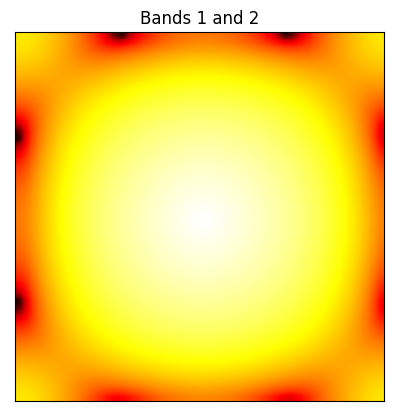

PyObject Text(0.5, 1.0, 'Bands 1 and 2')

In [39]:
imshow(log.(np.roll(bands2_reshaped - bands1_reshaped, (0,0), axis=(0, 1))), cmap="hot", interpolation="gaussian")
xticks(Float64[])
yticks(Float64[])
title("Bands 1 and 2")

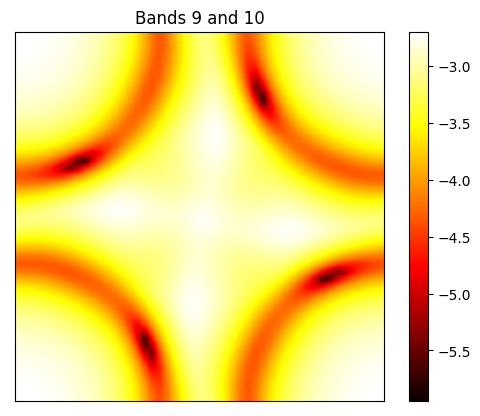

PyObject <matplotlib.colorbar.Colorbar object at 0x7fa075a56b50>

In [37]:
imshow(log.(np.roll(bands10_reshaped - bands9_reshaped, (0,0), axis=(0, 1))), cmap="hot", interpolation="gaussian")
xticks(Float64[])
yticks(Float64[])

title("Bands 9 and 10")
colorbar()

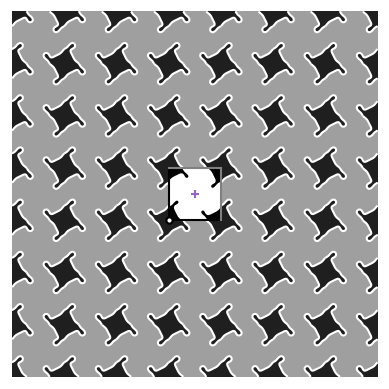

(-0.5:0.010101010101010102:0.5, [-2.53972 -2.5399937954760072 … -2.5399937954760077 -2.53972; -2.5399937954760072 -2.5403023908585856 … -2.540302390858586 -2.5399937954760077; … ; -2.5399937954760077 -2.540302390858586 … -2.5403023908585856 -2.5399937954760072; -2.53972 -2.5399937954760077 … -2.5399937954760072 -2.53972], -0.9492059983588146)

In [9]:
plot_lattice_from_mpbparams("./nodal_points/input/dim2-sg10-20004-res64-te.sh", repeat=3)